In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

/opt/miniconda3/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(('lat')).mean('lon')
def global_root_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return np.sqrt(ds.weighted(weights).mean(('lat')).mean('lon'))

In [3]:
import xarray as xr
import glob

def load_files(base_path, metric, file_pattern):
    # Define the base path
    pattern = base_path + file_pattern
    subdirectories = glob.glob(pattern)
    print(len(subdirectories))

    # Initialize an empty list to store xarray datasets
    datasets = []

    # Iterate over each subdirectory
    for subdirectory in sorted(subdirectories):
        # Construct the full path to ensemble_mse.zarr within each subdirectory
        file_path = subdirectory + f"/{metric}.zarr"
        
        if 'tmp' in file_path: continue
        # Open the Zarr file as an xarray dataset
        ds = xr.open_zarr(file_path)
        
        ds = ds.assign_coords(initial_time=ds["time"][0].values)
        ds = ds.drop_vars("lon")
        ds["time"] = ds["time"] - ds["time"][0]

        # Append the dataset to the list of datasets
        datasets.append(ds)
    output = xr.concat(datasets, dim="initial_time").mean(dim="initial_time")
    output.attrs.update(ds.attrs)

    # Concatenate all datasets along the time dimension
    return output

variance_combined = global_root_mean(load_files("/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0/",
                  "variance", "2018*")).load()
ensemble_mse_combined = global_root_mean(load_files("/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0/",
                  "ensemble_mse", "2018*")).load()

52
52


In [4]:
variance_bred = global_root_mean(load_files("/pscratch/sd/a/amahesh/hens/time_collection/bred_1checkpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0/",
                  "variance", "2018*")).load()
ensemble_mse_bred = global_root_mean(load_files("/pscratch/sd/a/amahesh/hens/time_collection/bred_1checkpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0/",
                  "ensemble_mse", "2018*")).load()

52
52


In [5]:
variance_mc = global_root_mean(load_files("/pscratch/sd/a/amahesh/hens/time_collection/nopert_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0/",
                  "variance", "2018*")).load()
ensemble_mse_mc = global_root_mean(load_files("/pscratch/sd/a/amahesh/hens/time_collection/nopert_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0/",
                  "ensemble_mse", "2018*")).load()

52
52


In [6]:
variance_mc['time'] = variance_mc['time'] / 3.6e+12
variance_bred['time'] = variance_bred['time'] / 3.6e+12
variance_combined['time'] = variance_combined['time'] / 3.6e+12
ensemble_mse_mc['time'] = ensemble_mse_mc['time'] / 3.6e+12
ensemble_mse_bred['time'] = ensemble_mse_bred['time'] / 3.6e+12
ensemble_mse_combined['time'] = ensemble_mse_combined['time'] / 3.6e+12


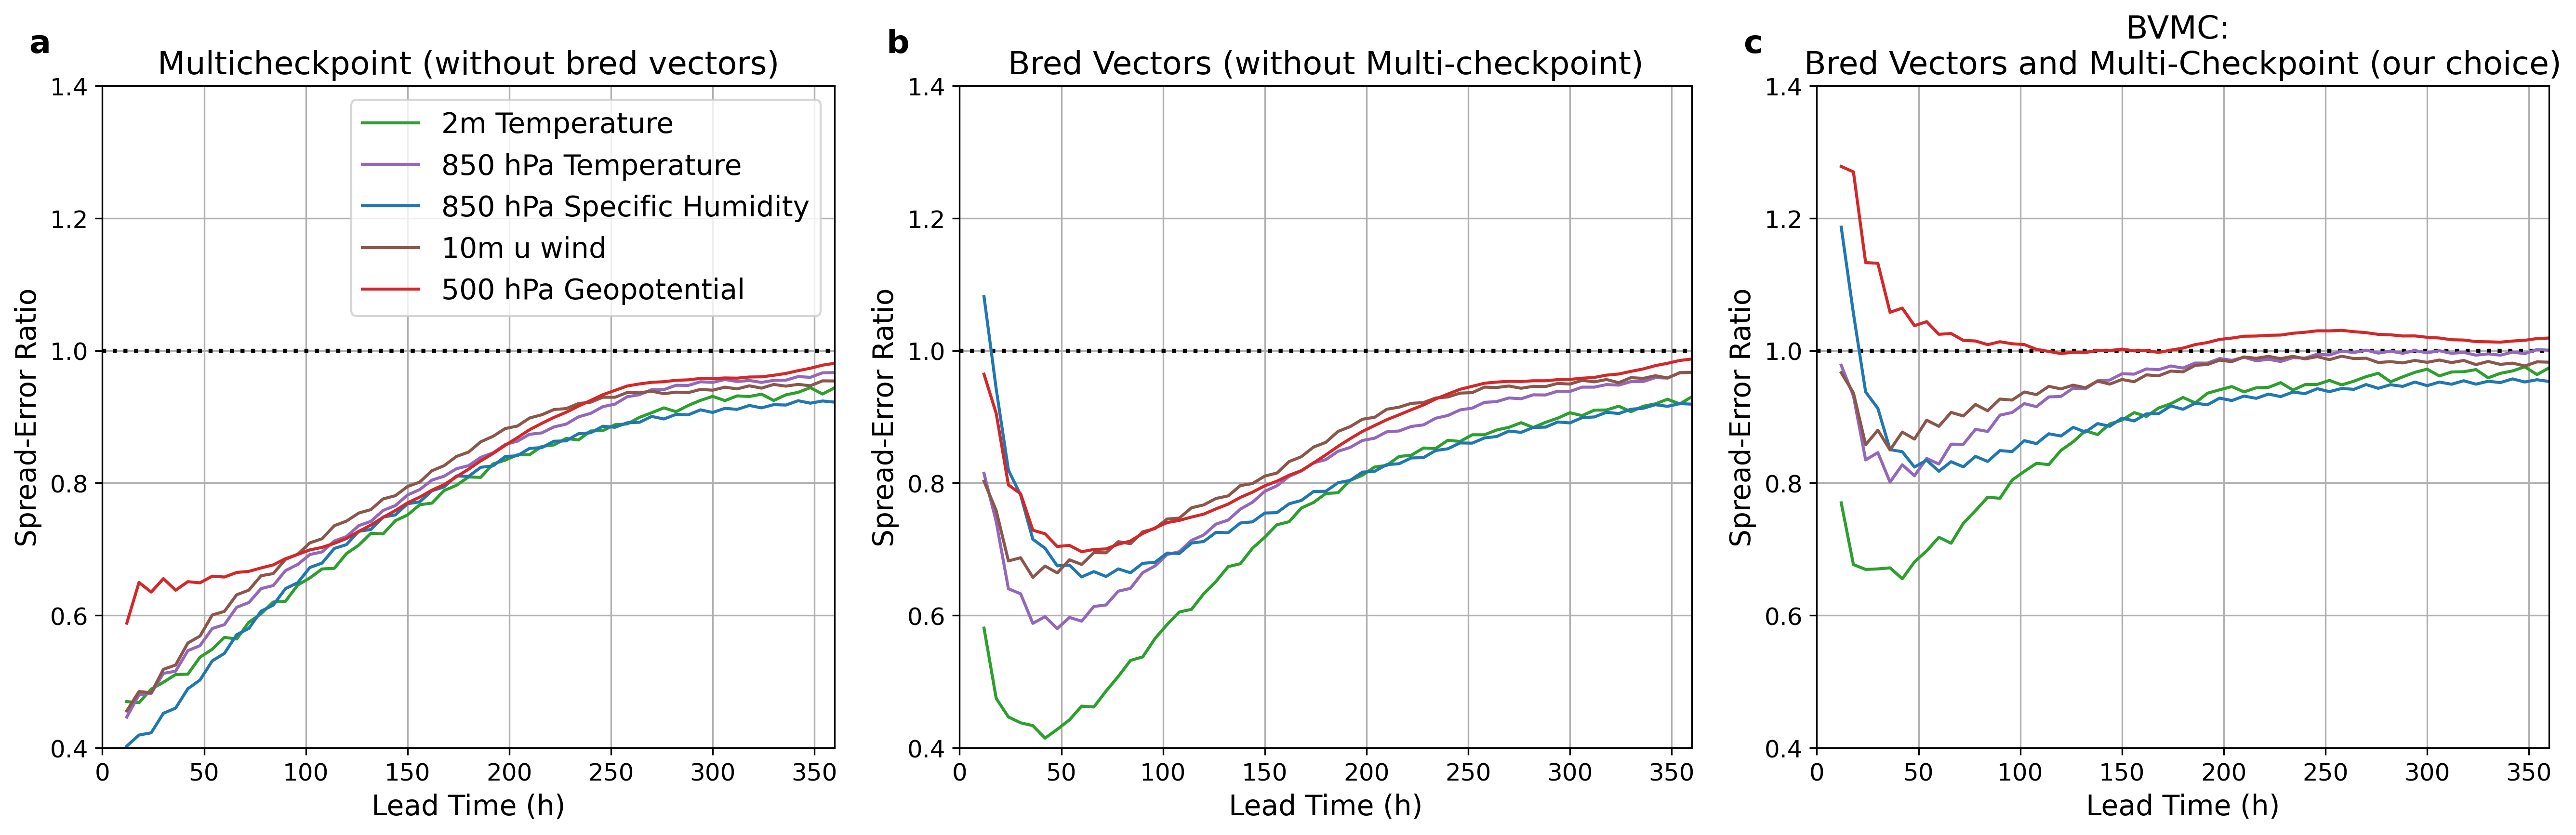

In [8]:
import matplotlib.pyplot as plt

var_to_color = {
    'q850': 'C0', 
    'u10m': 'C5', 
    'z500': 'C3', 
    't2m': 'C2',
    't850': 'C4'
}

full_name = {
    'q850' : '850 hPa Specific Humidity',
    'u10m' : '10m u wind',
    'z500' : '500 hPa Geopotential',
    't2m' : '2m Temperature',
    't850' : '850 hPa Temperature'
}

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})

# Creating a figure with 3 subplots in 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
axs[0].axhline(1.0, linestyle='dotted', color='black', linewidth=2)
axs[1].axhline(1.0, linestyle='dotted', color='black', linewidth=2)
axs[2].axhline(1.0, linestyle='dotted', color='black', linewidth=2)

# Plotting the first panel
for var in ['t2m', 't850', 'q850', 'u10m', 'z500']:
    axs[0].plot(ensemble_mse_combined['time'], (variance_mc[var] / ensemble_mse_mc[var]).isel(time=slice(2, 62)), label=full_name[var], color=var_to_color[var])
axs[0].legend()
axs[0].set_title('Multicheckpoint (without bred vectors)')
axs[0].set_ylim(0.4, 1.4)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Ratio')

# Plotting the second panel
for var in ['t2m', 't850', 'q850', 'u10m', 'z500']:
    axs[1].plot(ensemble_mse_combined['time'], (variance_bred[var] / ensemble_mse_bred[var]).isel(time=slice(2, 62)), label=full_name[var], color=var_to_color[var])
axs[1].set_title('Bred Vectors (without Multi-checkpoint)')
axs[1].set_ylim(0.4, 1.4)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Ratio')

# Plotting the third panel
for var in ['t2m', 't850', 'q850', 'u10m', 'z500']:
    axs[2].plot(ensemble_mse_combined['time'], (variance_combined[var] / ensemble_mse_combined[var]).isel(time=slice(2, 62)), label=full_name[var], color=var_to_color[var])
axs[2].set_title('BVMC: \nBred Vectors and Multi-Checkpoint (our choice)')
axs[2].set_ylim(0.4, 1.4)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Ratio')
axs[1].grid()
axs[2].grid()
axs[0].grid()
axs[0].set_xlabel("Lead Time (h)")
axs[1].set_xlabel("Lead Time (h)")
axs[2].set_xlabel("Lead Time (h)")

axs[0].set_ylabel("Spread-Error Ratio")
axs[1].set_ylabel("Spread-Error Ratio")
axs[2].set_ylabel("Spread-Error Ratio")

axs[0].set_xlim((0, 360))
axs[1].set_xlim((0, 360))
axs[2].set_xlim((0, 360))

# Adding labels 'a', 'b', 'c' to the subplots
axs[0].text(-0.1, 1.05, 'a', transform=axs[0].transAxes, size=16, weight='bold')
axs[1].text(-0.1, 1.05, 'b', transform=axs[1].transAxes, size=16, weight='bold')
axs[2].text(-0.1, 1.05, 'c', transform=axs[2].transAxes, size=16, weight='bold')

# Adjusting layout and saving
plt.tight_layout()
# plt.savefig("bred_mc_decomposition.pdf")
plt.show()
